In [ ]:
import pandas as pd

ny_path = "/home/fuest/EnData/data/pecanstreet/15minute_data_newyork.csv"
austin_path = "/home/fuest/EnData/data/pecanstreet/15minute_data_austin.csv"
cali_path = "/home/fuest/EnData/data/pecanstreet/15minute_data_california.csv"

ny_data = pd.read_csv(ny_path)
austin_data = pd.read_csv(austin_path)
cali_data = pd.read_csv(cali_path)

ny_user_ids = ny_data.dataid.unique()
austin_user_ids = austin_data.dataid.unique()
cali_user_ids = cali_data.dataid.unique()
austin_user_ids

In [ ]:
a = train_dataset.dataset.data
a[(a.month==7) & (a.weekday==0)]

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
from data_utils.dataset import PecanStreetDataset

def plot_grid_profile(df, month, weekday):
    # Filter the DataFrame based on the specified month and weekday
    filtered_df = df[(df['month'] == month) & (df['weekday'] == weekday)]
    
    # Check if there are any rows after filtering
    if filtered_df.empty:
        print(f"No data available for month {month} and weekday {weekday}.")
        return

    # Convert the 'grid' column to a list of arrays
    grid_values = filtered_df['grid'].apply(np.array).values

    # Calculate the average grid values for each 15-minute interval across all filtered rows
    averaged_grid = np.mean(np.vstack(grid_values), axis=0)

    # Generate 96 timestamps for a day at 15-minute intervals
    timestamps = pd.date_range(start='00:00', end='23:45', freq='15T').strftime('%H:%M')

    # Ensure that the lengths match
    if len(averaged_grid) != len(timestamps):
        raise ValueError(f"Length of averaged_grid ({len(averaged_grid)}) does not match length of timestamps ({len(timestamps)}).")

    # Plot the averaged grid profile
    plt.figure(figsize=(12, 6))
    plt.plot(timestamps, averaged_grid, marker='o')
    plt.title(f'Grid Profile for Month {month} and Weekday {weekday}')
    plt.xlabel('Time of Day')
    plt.ylabel('Grid Values')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

df = PecanStreetDataset(normalize=False).data
plot_grid_profile(df, month=5, weekday=3)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from data_utils.dataset import PecanStreetDataset

def plot_grid_profile(df, month, weekday, dataid=None, ax=None):
    filtered_df = df[(df['month'] == month) & (df['weekday'] == weekday)]
    if dataid is not None:
        filtered_df = filtered_df[filtered_df['dataid'] == dataid]
    
    if filtered_df.empty:
        print(f"No data available for month {month} and weekday {weekday} with dataid {dataid}.")
        return

    grid_values = filtered_df['grid'].apply(np.array).values
    averaged_grid = np.mean(np.vstack(grid_values), axis=0)
    timestamps = pd.date_range(start='00:00', end='23:45', freq='15T').strftime('%H:%M')

    if len(averaged_grid) != len(timestamps):
        raise ValueError(f"Length of averaged_grid ({len(averaged_grid)}) does not match length of timestamps ({len(timestamps)}).")
    
    if ax is None:
        plt.figure(figsize=(12, 6))
        plt.plot(timestamps, averaged_grid, marker='o')
        title = f'Grid Profile for Month {month} and Weekday {weekday}'
        if dataid is not None:
            title += f' (DataID: {dataid})'
        plt.title(title)
        plt.xlabel('Time of Day')
        plt.ylabel('Grid Values')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        ax.plot(timestamps, averaged_grid, marker='o', label=f'DataID: {dataid}')

def plot_all_users_grid_profile(df, month, weekday):
    unique_dataids = df['dataid'].unique()
    fig, ax = plt.subplots(figsize=(12, 6))
    for dataid in unique_dataids:
        plot_grid_profile(df, month, weekday, dataid, ax=ax)
    
    title = f'Grid Profile for Month {month} and Weekday {weekday} for All Users'
    plt.title(title)
    plt.xlabel('Time of Day')
    plt.ylabel('Grid Values')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

df = PecanStreetDataset(normalize=True).data
plot_all_users_grid_profile(df, month=11, weekday=3)

In [ ]:
def plot_daily_usage_profiles(df, dataid, month, weekday):
    # Filter the DataFrame based on the specified user id, month, and weekday
    filtered_df = df[(df['dataid'] == dataid) & (df['month'] == month) & (df['weekday'] == weekday)]
    
    # Check if there are any rows after filtering
    if filtered_df.empty:
        print(f"No data available for user {dataid}, month {month}, and weekday {weekday}.")
        return

    grid_values = filtered_df['grid'].apply(np.array).values
    timestamps = pd.date_range(start='00:00', end='23:45', freq='15T').strftime('%H:%M')

    plt.figure(figsize=(12, 6))
    for i, daily_grid in enumerate(grid_values):
        plt.plot(timestamps, daily_grid, marker='o', label=f'Day {i+1}')

    title = f'Daily Usage Profiles for User {dataid}, Month {month}, Weekday {weekday}'
    plt.title(title)
    plt.xlabel('Time of Day')
    plt.ylabel('Grid Values')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

df = PecanStreetDataset(normalize=False).data
plot_daily_usage_profiles(df, dataid=3687, month=5, weekday=0)

In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from data_utils.dataset import PecanStreetDataset, prepare_dataloader, split_dataset
from generator.acgan import ACGAN  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data = PecanStreetDataset(normalize=True, user_id=27)
train_dataset, val_dataset = split_dataset(data)
model = ACGAN(
    input_dim=1,
    noise_dim=512,
    embedding_dim=512,
    output_dim=96,
    learning_rate=1e-4,
    weight_path="runs/",
)
model.train(train_dataset, val_dataset, batch_size=32, num_epoch=100)

def generate_and_plot_series(model, day_labels, month_labels, data, month, weekday):
    series1 = model.generate([day_labels, month_labels]).squeeze()
    series2 = model.generate([day_labels, month_labels]).squeeze()
    series3 = model.generate([day_labels, month_labels]).squeeze()

    timestamps = pd.date_range(start='00:00', periods=96, freq='15T').strftime('%H:%M')

    filtered_data = data[(data['month'] == month) & (data['weekday'] == weekday)]
    real_profiles = filtered_data.sample(3)['grid'].values
    real_profile1 = np.array(real_profiles[0])
    real_profile2 = np.array(real_profiles[1])
    real_profile3 = np.array(real_profiles[2])

    # Plot all series on the same plot
    plt.figure(figsize=(15, 6))
    plt.plot(timestamps, series1, label='Generated Profile 1')
    plt.plot(timestamps, series2, label='Generated Profile 2')
    plt.plot(timestamps, series3, label='Generated Profile 3')
    plt.plot(timestamps, real_profile1, label='Real Profile 1', linestyle='--')
    plt.plot(timestamps, real_profile2, label='Real Profile 2', linestyle='--')
    plt.plot(timestamps, real_profile3, label='Real Profile 3', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Generated and Real Time Series Profiles')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

day_labels = torch.tensor([6]).to(device)
month_labels = torch.tensor([5]).to(device)

generate_and_plot_series(model, day_labels, month_labels, data.data, 5, 6)

In [7]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt

from generator.acgan import ACGAN  
from data_utils.dataset import PecanStreetDataset, split_dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def plot_range_with_values(df, colname, values_to_compare):
    values_to_compare = values_to_compare
    filtered_df =df
    array_data = np.array(filtered_df[colname].to_list())
    min_values = np.min(array_data, axis=0)
    max_values = np.max(array_data, axis=0)
    timestamps = pd.date_range(start='00:00', end='23:45', freq='15T').strftime('%H:%M')
    
    plt.figure(figsize=(15, 7))
    plt.fill_between(timestamps, min_values, max_values, color='gray', alpha=0.5, label='Range of values')
    plt.plot(timestamps, values_to_compare, color='blue', marker='o', label='Values to Compare')
    
    plt.title('Range of Values and Comparison')
    plt.xlabel('Time of Day')
    plt.ylabel('Values')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
from data_utils.dataset import PecanStreetDataset, split_dataset
import pandas as pd

normalized_dataset = PecanStreetDataset(normalize=True, user_id=1642, include_generation=False)
original_dataset = PecanStreetDataset(normalize=False, user_id=1642, include_generation=False)

In [1]:
import pandas as pd
import numpy as np

from data_utils.dataset import PecanStreetDataset, prepare_dataloader, split_dataset
from eval.metrics import (
    Context_FID,
    calculate_period_bound_mse,
    dynamic_time_warping_dist,
)
from generator.acgan import ACGAN

data = PecanStreetDataset(normalize=True, user_id=661, include_generation=False, threshold=(-2, 2))
train_dataset, val_dataset = split_dataset(data)
model = ACGAN(
    input_dim=1,
    noise_dim=512,
    embedding_dim=512,
    window_length=96,
    learning_rate=5e-4,
    weight_path="runs/",
)
model.train(train_dataset, val_dataset, batch_size=32, num_epoch=100)

_, _, syn_ts_df = model.generate_data_for_eval(data.data)
unnormalized_syn = data.inverse_transform(syn_ts_df, 661, 'grid')
unnormalized_ori = data.inverse_transform(data.data, 661, 'grid')
syn = np.expand_dims(np.array(unnormalized_syn["grid"].tolist()), axis=-1)
ori = np.expand_dims(np.array(unnormalized_ori["grid"].tolist()), axis=-1)

print(f"Context FID: {Context_FID(ori, syn)}")
print(f"Dynamic Time Warping Distance: {dynamic_time_warping_dist(ori, syn)}")
print(
    f"Period bound MSE: {calculate_period_bound_mse(timeseries_array=syn, df=data.data, timeseries_colname='grid')}"
)

Epoch 1: 100%|██████████| 9/9 [00:00<00:00, 11.73it/s]


Epoch [1/100], Mean MMD Loss: [0.00619111]


Epoch 2: 100%|██████████| 9/9 [00:00<00:00, 23.54it/s]


Epoch [2/100], Mean MMD Loss: [0.00562109]


Epoch 3: 100%|██████████| 9/9 [00:00<00:00, 26.45it/s]


Epoch [3/100], Mean MMD Loss: [0.00579894]


Epoch 4: 100%|██████████| 9/9 [00:00<00:00, 22.87it/s]


Epoch [4/100], Mean MMD Loss: [0.00722962]


Epoch 5: 100%|██████████| 9/9 [00:00<00:00, 27.59it/s]


Epoch [5/100], Mean MMD Loss: [0.00681207]


Epoch 6: 100%|██████████| 9/9 [00:00<00:00, 27.09it/s]


Epoch [6/100], Mean MMD Loss: [0.00656494]


Epoch 7: 100%|██████████| 9/9 [00:00<00:00, 27.50it/s]


Epoch [7/100], Mean MMD Loss: [0.00457406]


Epoch 8: 100%|██████████| 9/9 [00:00<00:00, 22.66it/s]


Epoch [8/100], Mean MMD Loss: [0.00458623]


Epoch 9: 100%|██████████| 9/9 [00:00<00:00, 25.02it/s]


Epoch [9/100], Mean MMD Loss: [0.00573243]


Epoch 10: 100%|██████████| 9/9 [00:00<00:00, 27.47it/s]


Epoch [10/100], Mean MMD Loss: [0.0061459]


Epoch 11: 100%|██████████| 9/9 [00:00<00:00, 24.70it/s]


Epoch [11/100], Mean MMD Loss: [0.00493256]


Epoch 12: 100%|██████████| 9/9 [00:00<00:00, 22.96it/s]


Epoch [12/100], Mean MMD Loss: [0.00625312]


Epoch 13: 100%|██████████| 9/9 [00:00<00:00, 22.77it/s]


Epoch [13/100], Mean MMD Loss: [0.00628949]


Epoch 14: 100%|██████████| 9/9 [00:00<00:00, 23.60it/s]


Epoch [14/100], Mean MMD Loss: [0.00653487]


Epoch 15: 100%|██████████| 9/9 [00:00<00:00, 29.68it/s]


Epoch [15/100], Mean MMD Loss: [0.00864106]


Epoch 16: 100%|██████████| 9/9 [00:00<00:00, 26.66it/s]


Epoch [16/100], Mean MMD Loss: [0.00864383]


Epoch 17: 100%|██████████| 9/9 [00:00<00:00, 27.49it/s]


Epoch [17/100], Mean MMD Loss: [0.00766453]


Epoch 18: 100%|██████████| 9/9 [00:00<00:00, 29.73it/s]


Epoch [18/100], Mean MMD Loss: [0.00825731]


Epoch 19: 100%|██████████| 9/9 [00:00<00:00, 24.22it/s]


Epoch [19/100], Mean MMD Loss: [0.00571765]


Epoch 20: 100%|██████████| 9/9 [00:00<00:00, 25.03it/s]


Epoch [20/100], Mean MMD Loss: [0.00668134]


Epoch 21: 100%|██████████| 9/9 [00:00<00:00, 24.32it/s]


Epoch [21/100], Mean MMD Loss: [0.00659619]


Epoch 22: 100%|██████████| 9/9 [00:00<00:00, 26.38it/s]


Epoch [22/100], Mean MMD Loss: [0.00673183]


Epoch 23: 100%|██████████| 9/9 [00:00<00:00, 25.46it/s]


Epoch [23/100], Mean MMD Loss: [0.00616747]


Epoch 24: 100%|██████████| 9/9 [00:00<00:00, 28.58it/s]


Epoch [24/100], Mean MMD Loss: [0.00747885]


Epoch 25: 100%|██████████| 9/9 [00:00<00:00, 21.80it/s]


Epoch [25/100], Mean MMD Loss: [0.00785841]


Epoch 26: 100%|██████████| 9/9 [00:00<00:00, 26.34it/s]


Epoch [26/100], Mean MMD Loss: [0.00725977]


Epoch 27: 100%|██████████| 9/9 [00:00<00:00, 27.11it/s]


Epoch [27/100], Mean MMD Loss: [0.00614536]


Epoch 28: 100%|██████████| 9/9 [00:00<00:00, 25.85it/s]


Epoch [28/100], Mean MMD Loss: [0.00730938]


Epoch 29: 100%|██████████| 9/9 [00:00<00:00, 23.63it/s]


Epoch [29/100], Mean MMD Loss: [0.00629629]


Epoch 30: 100%|██████████| 9/9 [00:00<00:00, 26.84it/s]


Epoch [30/100], Mean MMD Loss: [0.00730221]


Epoch 31: 100%|██████████| 9/9 [00:00<00:00, 23.49it/s]


Epoch [31/100], Mean MMD Loss: [0.00691668]


Epoch 32: 100%|██████████| 9/9 [00:00<00:00, 26.35it/s]


Epoch [32/100], Mean MMD Loss: [0.00725044]


Epoch 33: 100%|██████████| 9/9 [00:00<00:00, 26.09it/s]


Epoch [33/100], Mean MMD Loss: [0.00757016]


Epoch 34: 100%|██████████| 9/9 [00:00<00:00, 27.68it/s]


Epoch [34/100], Mean MMD Loss: [0.00720436]


Epoch 35: 100%|██████████| 9/9 [00:00<00:00, 22.50it/s]


Epoch [35/100], Mean MMD Loss: [0.00902492]


Epoch 36: 100%|██████████| 9/9 [00:00<00:00, 28.80it/s]


Epoch [36/100], Mean MMD Loss: [0.00728958]


Epoch 37: 100%|██████████| 9/9 [00:00<00:00, 23.45it/s]


Epoch [37/100], Mean MMD Loss: [0.00981878]


Epoch 38: 100%|██████████| 9/9 [00:00<00:00, 24.44it/s]


Epoch [38/100], Mean MMD Loss: [0.007522]


Epoch 39: 100%|██████████| 9/9 [00:00<00:00, 22.07it/s]


Epoch [39/100], Mean MMD Loss: [0.00848918]


Epoch 40: 100%|██████████| 9/9 [00:00<00:00, 23.09it/s]


Epoch [40/100], Mean MMD Loss: [0.00705647]


Epoch 41: 100%|██████████| 9/9 [00:00<00:00, 23.15it/s]


Epoch [41/100], Mean MMD Loss: [0.01002184]


Epoch 42: 100%|██████████| 9/9 [00:00<00:00, 25.72it/s]


Epoch [42/100], Mean MMD Loss: [0.00714678]


Epoch 43: 100%|██████████| 9/9 [00:00<00:00, 24.07it/s]


Epoch [43/100], Mean MMD Loss: [0.0074907]


Epoch 44: 100%|██████████| 9/9 [00:00<00:00, 23.83it/s]


Epoch [44/100], Mean MMD Loss: [0.00930983]


Epoch 45: 100%|██████████| 9/9 [00:00<00:00, 27.82it/s]


Epoch [45/100], Mean MMD Loss: [0.00806618]


Epoch 46: 100%|██████████| 9/9 [00:00<00:00, 25.09it/s]


Epoch [46/100], Mean MMD Loss: [0.00706726]


Epoch 47: 100%|██████████| 9/9 [00:00<00:00, 23.20it/s]


Epoch [47/100], Mean MMD Loss: [0.00936261]


Epoch 48: 100%|██████████| 9/9 [00:00<00:00, 25.36it/s]


Epoch [48/100], Mean MMD Loss: [0.00857322]


Epoch 49: 100%|██████████| 9/9 [00:00<00:00, 23.51it/s]


Epoch [49/100], Mean MMD Loss: [0.00895509]


Epoch 50: 100%|██████████| 9/9 [00:00<00:00, 24.25it/s]


Epoch [50/100], Mean MMD Loss: [0.00783351]


Epoch 51: 100%|██████████| 9/9 [00:00<00:00, 27.00it/s]


Epoch [51/100], Mean MMD Loss: [0.0113384]


Epoch 52: 100%|██████████| 9/9 [00:00<00:00, 27.54it/s]


Epoch [52/100], Mean MMD Loss: [0.01033529]


Epoch 53: 100%|██████████| 9/9 [00:00<00:00, 22.78it/s]


Epoch [53/100], Mean MMD Loss: [0.00973766]


Epoch 54: 100%|██████████| 9/9 [00:00<00:00, 25.41it/s]


Epoch [54/100], Mean MMD Loss: [0.00804052]


Epoch 55: 100%|██████████| 9/9 [00:00<00:00, 28.73it/s]


Epoch [55/100], Mean MMD Loss: [0.01117781]


Epoch 56: 100%|██████████| 9/9 [00:00<00:00, 29.14it/s]


Epoch [56/100], Mean MMD Loss: [0.00827088]


Epoch 57: 100%|██████████| 9/9 [00:00<00:00, 22.44it/s]


Epoch [57/100], Mean MMD Loss: [0.00672342]


Epoch 58: 100%|██████████| 9/9 [00:00<00:00, 23.88it/s]


Epoch [58/100], Mean MMD Loss: [0.00761559]


Epoch 59: 100%|██████████| 9/9 [00:00<00:00, 24.81it/s]


Epoch [59/100], Mean MMD Loss: [0.00864278]


Epoch 60: 100%|██████████| 9/9 [00:00<00:00, 21.47it/s]


Epoch [60/100], Mean MMD Loss: [0.00765251]


Epoch 61: 100%|██████████| 9/9 [00:00<00:00, 26.00it/s]


Epoch [61/100], Mean MMD Loss: [0.00863697]


Epoch 62: 100%|██████████| 9/9 [00:00<00:00, 26.69it/s]


Epoch [62/100], Mean MMD Loss: [0.00745235]


Epoch 63: 100%|██████████| 9/9 [00:00<00:00, 29.17it/s]


Epoch [63/100], Mean MMD Loss: [0.00984176]


Epoch 64: 100%|██████████| 9/9 [00:00<00:00, 26.91it/s]


Epoch [64/100], Mean MMD Loss: [0.0100911]


Epoch 65: 100%|██████████| 9/9 [00:00<00:00, 23.50it/s]


Epoch [65/100], Mean MMD Loss: [0.0081598]


Epoch 66: 100%|██████████| 9/9 [00:00<00:00, 24.11it/s]


Epoch [66/100], Mean MMD Loss: [0.00968271]


Epoch 67: 100%|██████████| 9/9 [00:00<00:00, 27.51it/s]


Epoch [67/100], Mean MMD Loss: [0.0089365]


Epoch 68: 100%|██████████| 9/9 [00:00<00:00, 27.29it/s]


Epoch [68/100], Mean MMD Loss: [0.01010726]


Epoch 69: 100%|██████████| 9/9 [00:00<00:00, 20.95it/s]


Epoch [69/100], Mean MMD Loss: [0.01555335]


Epoch 70: 100%|██████████| 9/9 [00:00<00:00, 23.73it/s]


Epoch [70/100], Mean MMD Loss: [0.00930555]


Epoch 71: 100%|██████████| 9/9 [00:00<00:00, 23.52it/s]


Epoch [71/100], Mean MMD Loss: [0.01342483]


Epoch 72: 100%|██████████| 9/9 [00:00<00:00, 27.41it/s]


Epoch [72/100], Mean MMD Loss: [0.00899996]


Epoch 73: 100%|██████████| 9/9 [00:00<00:00, 29.41it/s]


Epoch [73/100], Mean MMD Loss: [0.00894983]


Epoch 74: 100%|██████████| 9/9 [00:00<00:00, 24.23it/s]


Epoch [74/100], Mean MMD Loss: [0.0090157]


Epoch 75: 100%|██████████| 9/9 [00:00<00:00, 23.53it/s]


Epoch [75/100], Mean MMD Loss: [0.00928517]


Epoch 76: 100%|██████████| 9/9 [00:00<00:00, 22.27it/s]


Epoch [76/100], Mean MMD Loss: [0.01056474]


Epoch 77: 100%|██████████| 9/9 [00:00<00:00, 27.03it/s]


Epoch [77/100], Mean MMD Loss: [0.01134349]


Epoch 78: 100%|██████████| 9/9 [00:00<00:00, 23.26it/s]


Epoch [78/100], Mean MMD Loss: [0.00849598]


Epoch 79: 100%|██████████| 9/9 [00:00<00:00, 27.90it/s]


Epoch [79/100], Mean MMD Loss: [0.01092493]


Epoch 80: 100%|██████████| 9/9 [00:00<00:00, 27.20it/s]


Epoch [80/100], Mean MMD Loss: [0.00951664]


Epoch 81: 100%|██████████| 9/9 [00:00<00:00, 28.67it/s]


Epoch [81/100], Mean MMD Loss: [0.01085026]


Epoch 82: 100%|██████████| 9/9 [00:00<00:00, 27.15it/s]


Epoch [82/100], Mean MMD Loss: [0.01209858]


Epoch 83: 100%|██████████| 9/9 [00:00<00:00, 26.34it/s]


Epoch [83/100], Mean MMD Loss: [0.01187161]


Epoch 84: 100%|██████████| 9/9 [00:00<00:00, 28.51it/s]


Epoch [84/100], Mean MMD Loss: [0.00898035]


Epoch 85: 100%|██████████| 9/9 [00:00<00:00, 24.36it/s]


Epoch [85/100], Mean MMD Loss: [0.01248099]


Epoch 86: 100%|██████████| 9/9 [00:00<00:00, 23.56it/s]


Epoch [86/100], Mean MMD Loss: [0.01727599]


Epoch 87: 100%|██████████| 9/9 [00:00<00:00, 27.27it/s]


Epoch [87/100], Mean MMD Loss: [0.01546073]


Epoch 88: 100%|██████████| 9/9 [00:00<00:00, 22.28it/s]


Epoch [88/100], Mean MMD Loss: [0.00901475]


Epoch 89: 100%|██████████| 9/9 [00:00<00:00, 23.06it/s]


Epoch [89/100], Mean MMD Loss: [0.01480009]


Epoch 90: 100%|██████████| 9/9 [00:00<00:00, 29.03it/s]


Epoch [90/100], Mean MMD Loss: [0.01630347]


Epoch 91: 100%|██████████| 9/9 [00:00<00:00, 23.18it/s]


Epoch [91/100], Mean MMD Loss: [0.01016241]


Epoch 92: 100%|██████████| 9/9 [00:00<00:00, 24.17it/s]


Epoch [92/100], Mean MMD Loss: [0.00844546]


Epoch 93: 100%|██████████| 9/9 [00:00<00:00, 24.28it/s]


Epoch [93/100], Mean MMD Loss: [0.00922019]


Epoch 94: 100%|██████████| 9/9 [00:00<00:00, 25.63it/s]


Epoch [94/100], Mean MMD Loss: [0.01246333]


Epoch 95: 100%|██████████| 9/9 [00:00<00:00, 21.77it/s]


Epoch [95/100], Mean MMD Loss: [0.00917454]


Epoch 96: 100%|██████████| 9/9 [00:00<00:00, 23.27it/s]


Epoch [96/100], Mean MMD Loss: [0.01050212]


Epoch 97: 100%|██████████| 9/9 [00:00<00:00, 24.52it/s]


Epoch [97/100], Mean MMD Loss: [0.01236296]


Epoch 98: 100%|██████████| 9/9 [00:00<00:00, 22.37it/s]


Epoch [98/100], Mean MMD Loss: [0.00861566]


Epoch 99: 100%|██████████| 9/9 [00:00<00:00, 27.34it/s]


Epoch [99/100], Mean MMD Loss: [0.00941996]


Epoch 100: 100%|██████████| 9/9 [00:00<00:00, 22.06it/s]


Epoch [100/100], Mean MMD Loss: [0.00971268]
Context FID: 0.47948541195140926
Dynamic Time Warping Distance: 58.882068342160125
Period bound MSE: (2.899290628410999, 1.5434514985397922)


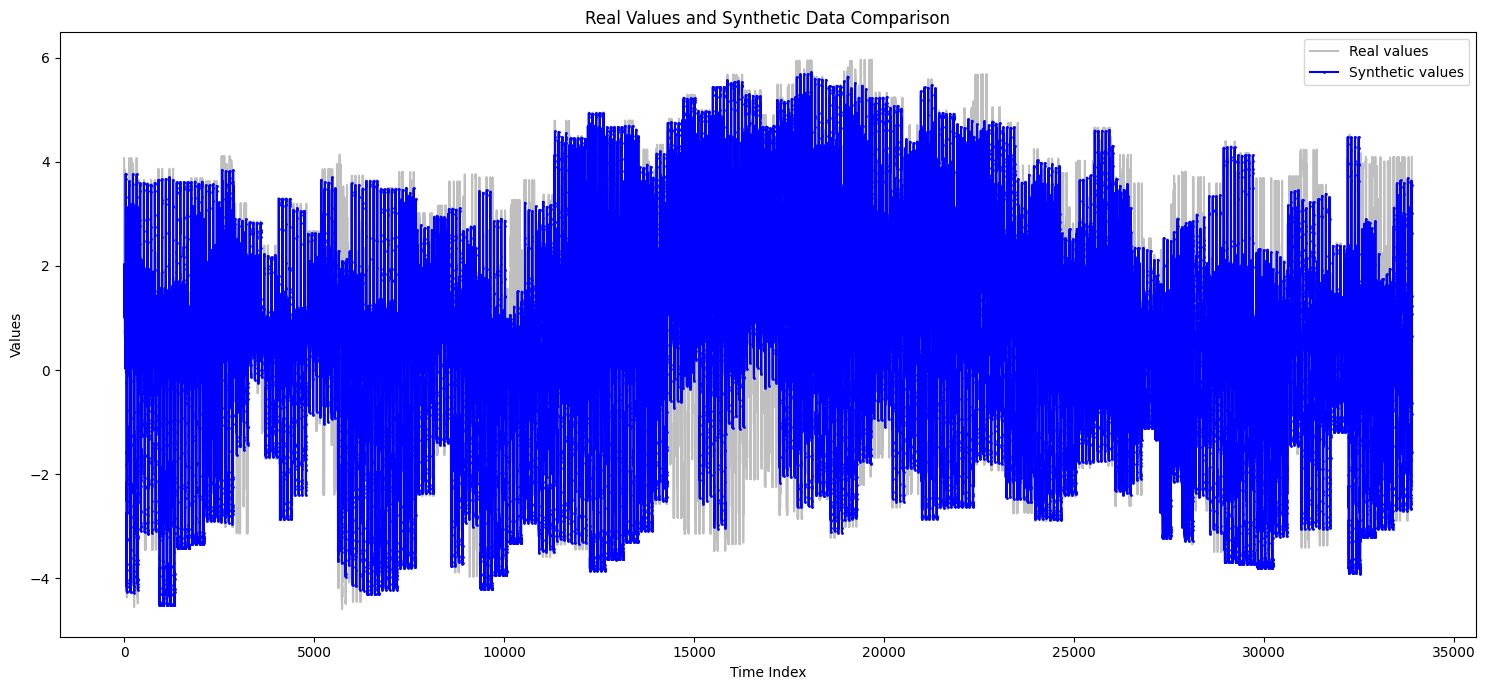

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_long_sequence(df, colname, syn):
    # Flatten the syn array to shape (353, 96)
    syn = syn.squeeze()

    # Create a long sequence of real values by concatenating all values in the 'grid' column
    real_values = np.concatenate(df[colname].to_list())

    # Create a long sequence of synthetic values by concatenating along the 0th axis
    syn_values = syn.flatten()

    # Generate indices for the x-axis
    real_indices = np.arange(len(real_values))
    syn_indices = np.arange(len(syn_values))

    plt.figure(figsize=(15, 7))
    plt.plot(real_indices, real_values, color='gray', alpha=0.5, label='Real values')
    plt.plot(syn_indices, syn_values, color='blue', marker='o', markersize=1, linestyle='-', label='Synthetic values')

    plt.title('Real Values and Synthetic Data Comparison')
    plt.xlabel('Time Index')
    plt.ylabel('Values')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_long_sequence(unnormalized_ori, 'grid', syn)


In [12]:
def plot_range_with_syn_values(df, colname, syn_df, month, weekday):
    # Filter the DataFrame for the given month and weekday
    filtered_df = df[(df['month'] == month) & (df['weekday'] == weekday)]
    
    # Ensure there is data for the given month and weekday
    if filtered_df.empty:
        print(f"No data for month={month}, weekday={weekday}")
        return
    
    # Convert the 'grid' column to a numpy array
    array_data = np.array(filtered_df[colname].to_list())

    # Calculate min and max values across all rows
    min_values = np.min(array_data, axis=0)
    max_values = np.max(array_data, axis=0)

    # Ensure the synthetic data DataFrame has the same structure and filter it
    syn_filtered_df = syn_df[(syn_df['month'] == month) & (syn_df['weekday'] == weekday)]

    # Ensure there is synthetic data for the given month and weekday
    if syn_filtered_df.empty:
        print(f"No synthetic data for month={month}, weekday={weekday}")
        return

    syn_values = np.array(syn_filtered_df['grid'].to_list()).squeeze()

    # Generate timestamps for the x-axis
    timestamps = pd.date_range(start='00:00', end='23:45', freq='15T').strftime('%H:%M')

    plt.figure(figsize=(15, 7))
    plt.fill_between(timestamps, min_values, max_values, color='gray', alpha=0.5, label='Range of values')
    
    # Plot the synthetic time series
    plt.plot(timestamps, syn_values[2], color='blue', marker='o', markersize=2, linestyle='-', label='Synthetic values')

    plt.title(f'Range of Values and Synthetic Data Comparison for Month={month}, Weekday={weekday}')
    plt.xlabel('Time of Day')
    plt.ylabel('Values')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

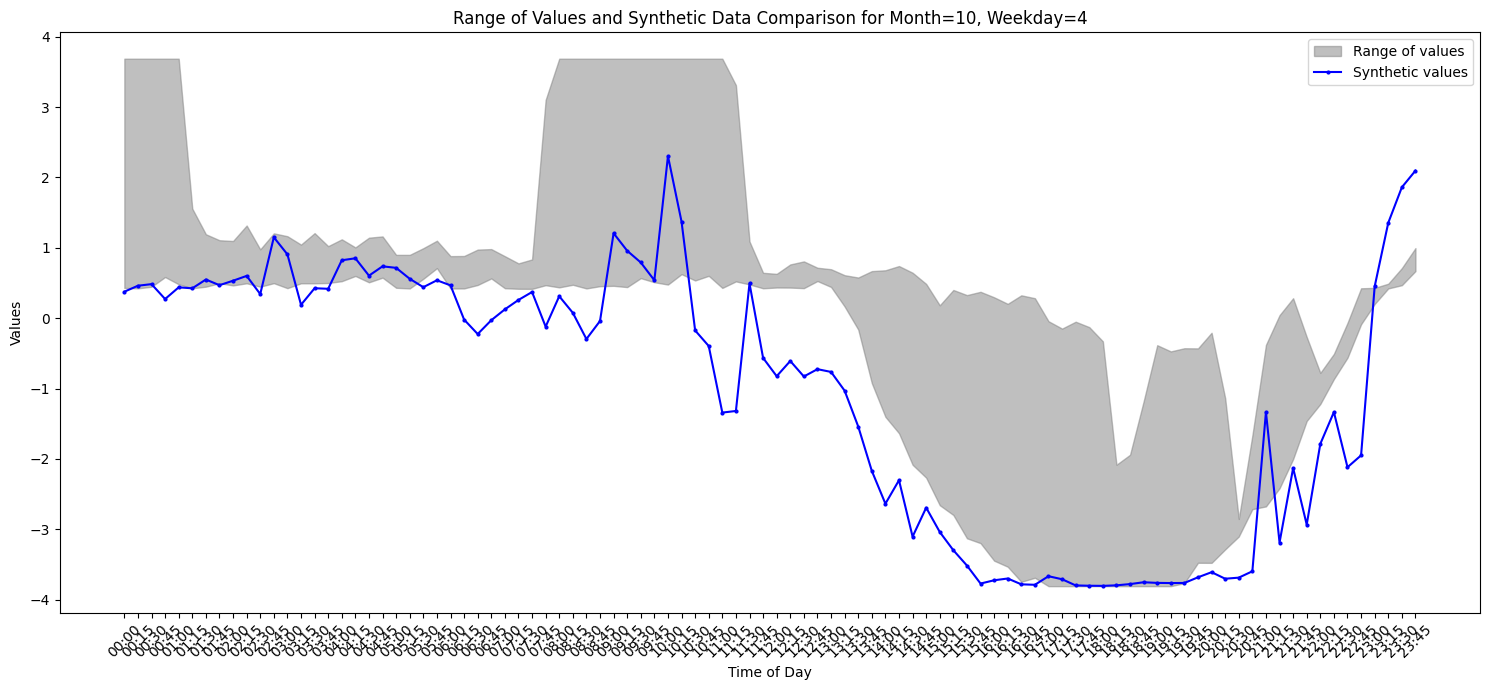

In [16]:
plot_range_with_syn_values(unnormalized_ori, 'grid', unnormalized_syn, 10, 4)